# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier


> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.


---
## Step 0: Load The Data

In [452]:
# Load pickled data
import pickle
import os
import glob
import random

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# Visualizations will be shown in the notebook.
%matplotlib inline       

from sklearn.utils import shuffle
from sklearn.utils import class_weight
from sklearn import metrics
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import confusion_matrix 

import cv2

import tensorflow as tf
from tensorflow.contrib.layers import flatten


output_path = "saved_model"

In [453]:


# Dataset Collection
dataset_dir = os.path.join('..','traffic-signs-data')
training_file = os.path.join(dataset_dir, 'train.p')
validation_file= os.path.join(dataset_dir, 'valid.p')
testing_file = os.path.join(dataset_dir, 'test.p')

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [454]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

training_set_samples_loaded = np.array(X_train)
validation_set_samples = np.array(X_valid)
test_set_samples = np.array(X_test)

training_set_labels = np.array(y_train)
validation_set_labels = np.array(y_valid)
test_set_labels = np.array(y_test)

train_sizes_vect = np.array(train['sizes'])
train_coords_vect = np.array(train['coords'])

# Number of training examples
n_train = training_set_samples_loaded.shape[0]

# Number of validation examples
n_validation = validation_set_samples.shape[0]

# Number of testing examples.
n_test = test_set_samples.shape[0]

# What's the shape of an traffic sign image?
image_shape = (training_set_samples_loaded.shape[1:])

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(training_set_labels))

# Assert lenghts of x,y arrays are consistent
assert(len(training_set_samples_loaded) == len(training_set_labels))
assert(len(validation_set_samples) == len(validation_set_labels))
assert(len(test_set_samples) == len(test_set_labels))


print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

Class label :  11  Signal Name :  Right-of-way at the next intersection
Index:  RangeIndex(start=0, stop=43, step=1)
Cols:  Index(['ClassId', 'SignName'], dtype='object')
Class labels:  ['Speed limit (20km/h)' 'Speed limit (30km/h)' 'Speed limit (50km/h)'
 'Speed limit (60km/h)' 'Speed limit (70km/h)' 'Speed limit (80km/h)'
 'End of speed limit (80km/h)' 'Speed limit (100km/h)'
 'Speed limit (120km/h)' 'No passing'
 'No passing for vehicles over 3.5 metric tons'
 'Right-of-way at the next intersection' 'Priority road' 'Yield' 'Stop'
 'No vehicles' 'Vehicles over 3.5 metric tons prohibited' 'No entry'
 'General caution' 'Dangerous curve to the left'
 'Dangerous curve to the right' 'Double curve' 'Bumpy road'
 'Slippery road' 'Road narrows on the right' 'Road work' 'Traffic signals'
 'Pedestrians' 'Children crossing' 'Bicycles crossing'
 'Beware of ice/snow' 'Wild animals crossing'
 'End of all speed and passing limits' 'Turn right ahead'
 'Turn left ahead' 'Ahead only' 'Go straight or r

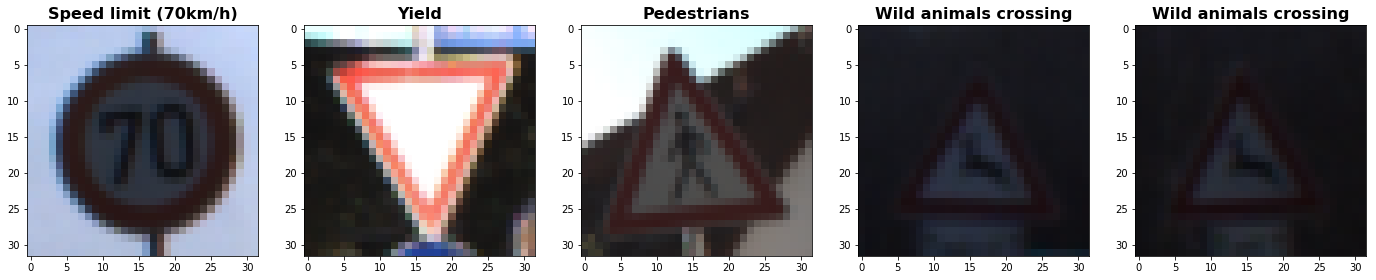

In [455]:
### Data exploration visualization code goes here.

def plot_images(images, labels=None):
    f,axes = plt.subplots(1, len(images), figsize=(24,24))
    for ind,image in enumerate(images):
        if image.shape[-1]==1:
            axes[ind].imshow(image.squeeze(axis=2), cmap='gray')
            if labels is not None:
                axes[ind].set_title(labels[ind], {'fontsize': 16,'fontweight' : 'bold'}) 
        else:
            axes[ind].imshow(image)
            if labels is not None:
                axes[ind].set_title(labels[ind], {'fontsize': 16,'fontweight' : 'bold'})
    
    plt.show()
        


# labels loaded as pandas DataFrame
labels = pd.read_csv('signnames.csv')


rand_label = y_train[index]
print('Class label : ', rand_label, ' Signal Name : ', labels.SignName[rand_label])

labels_idx = labels.index
labels_cols = labels.columns
labels_vals = labels.values

class_labels = labels['SignName'].values

print('Index: ', labels_idx)
print('Cols: ', labels_cols)

print('Class labels: ', class_labels)

indices = np.random.randint(0, n_train, size=5)
sample_images = training_set_samples_loaded[indices]
sample_labels = class_labels[training_set_labels[indices]]
plot_images(sample_images, sample_labels)

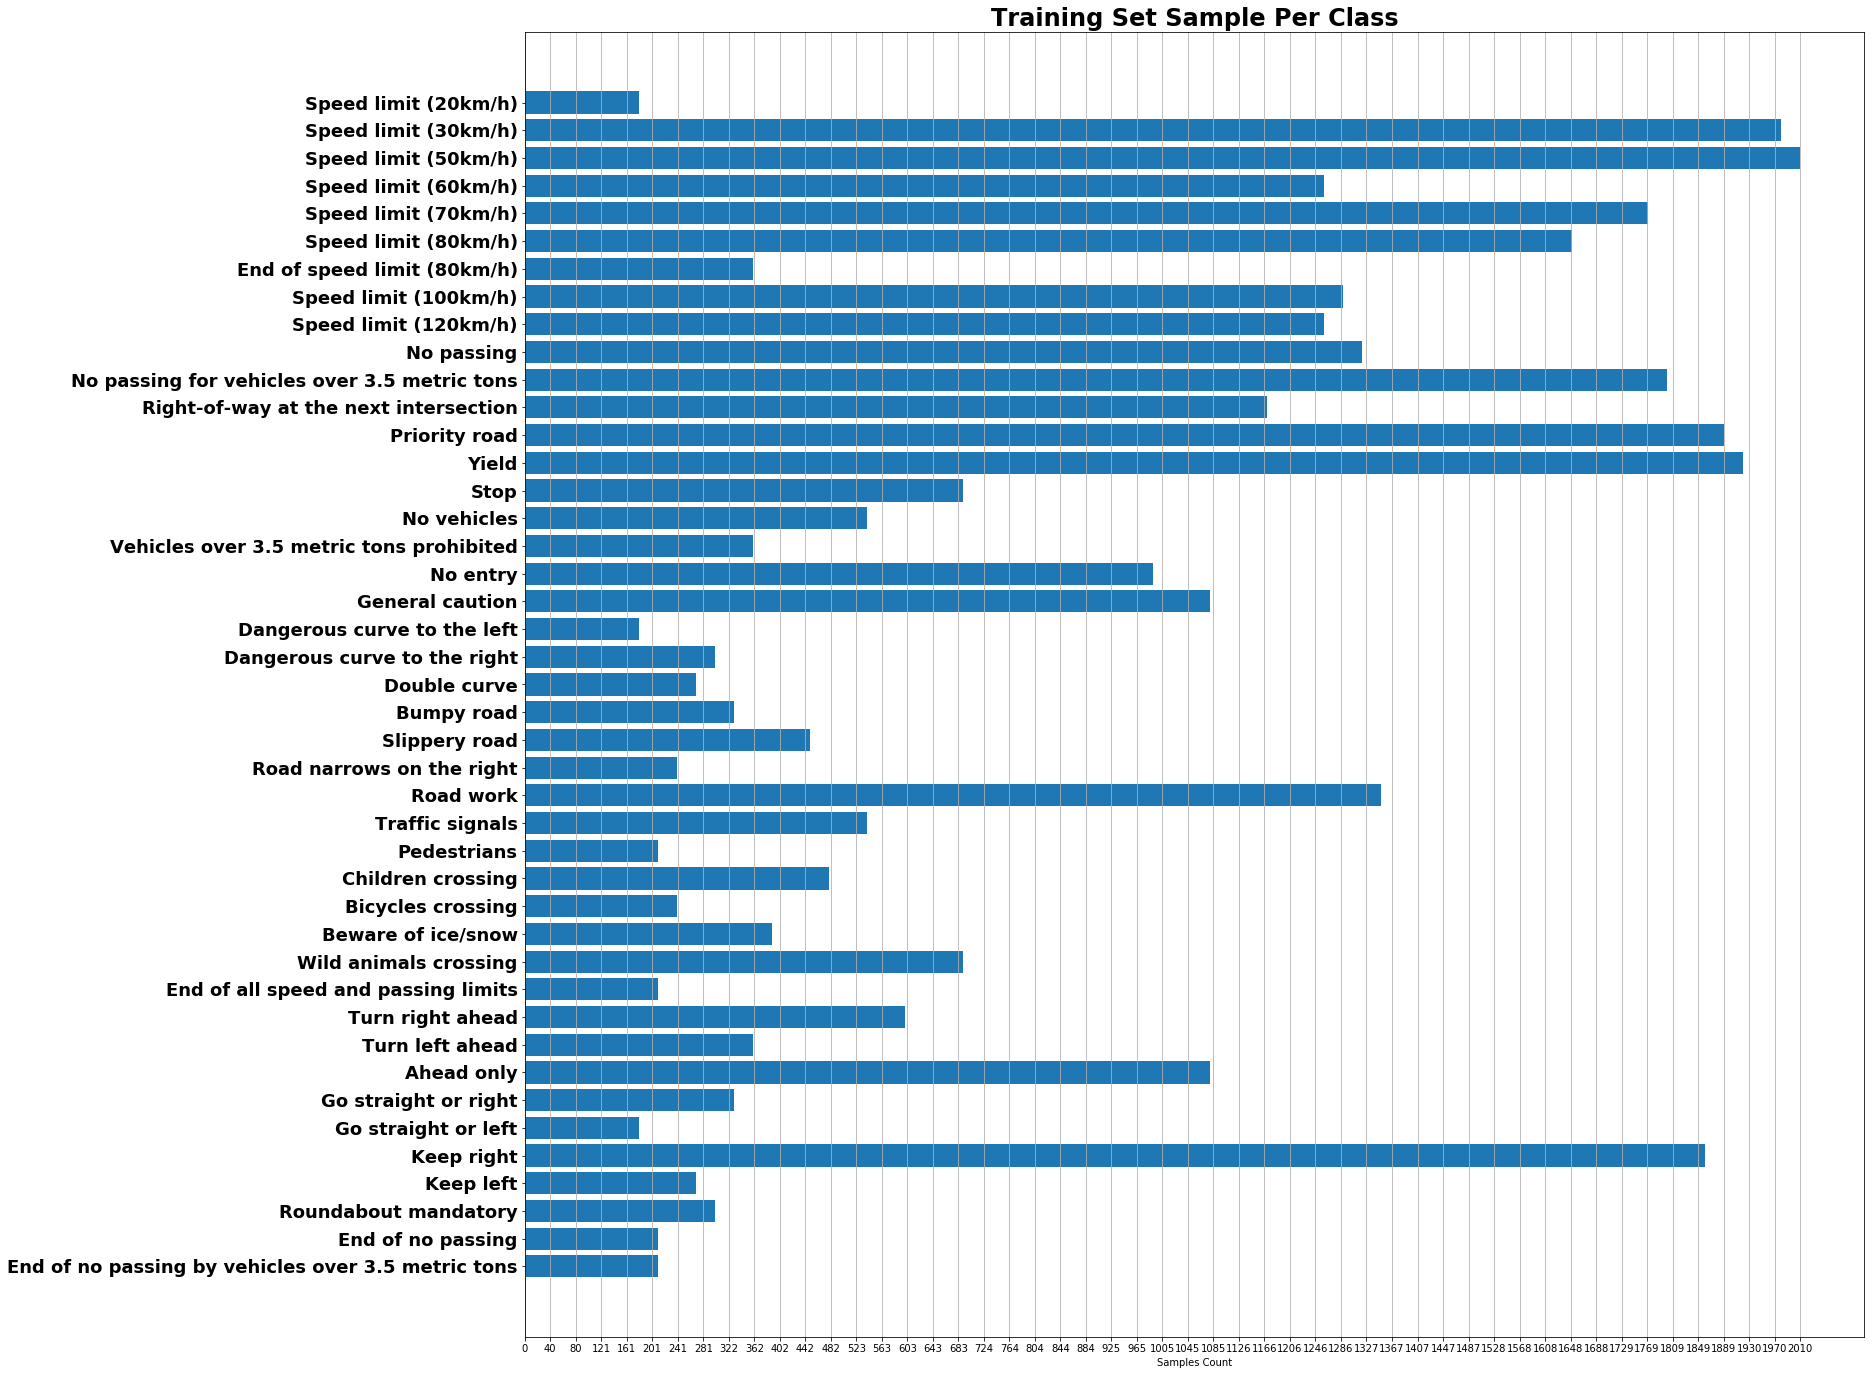

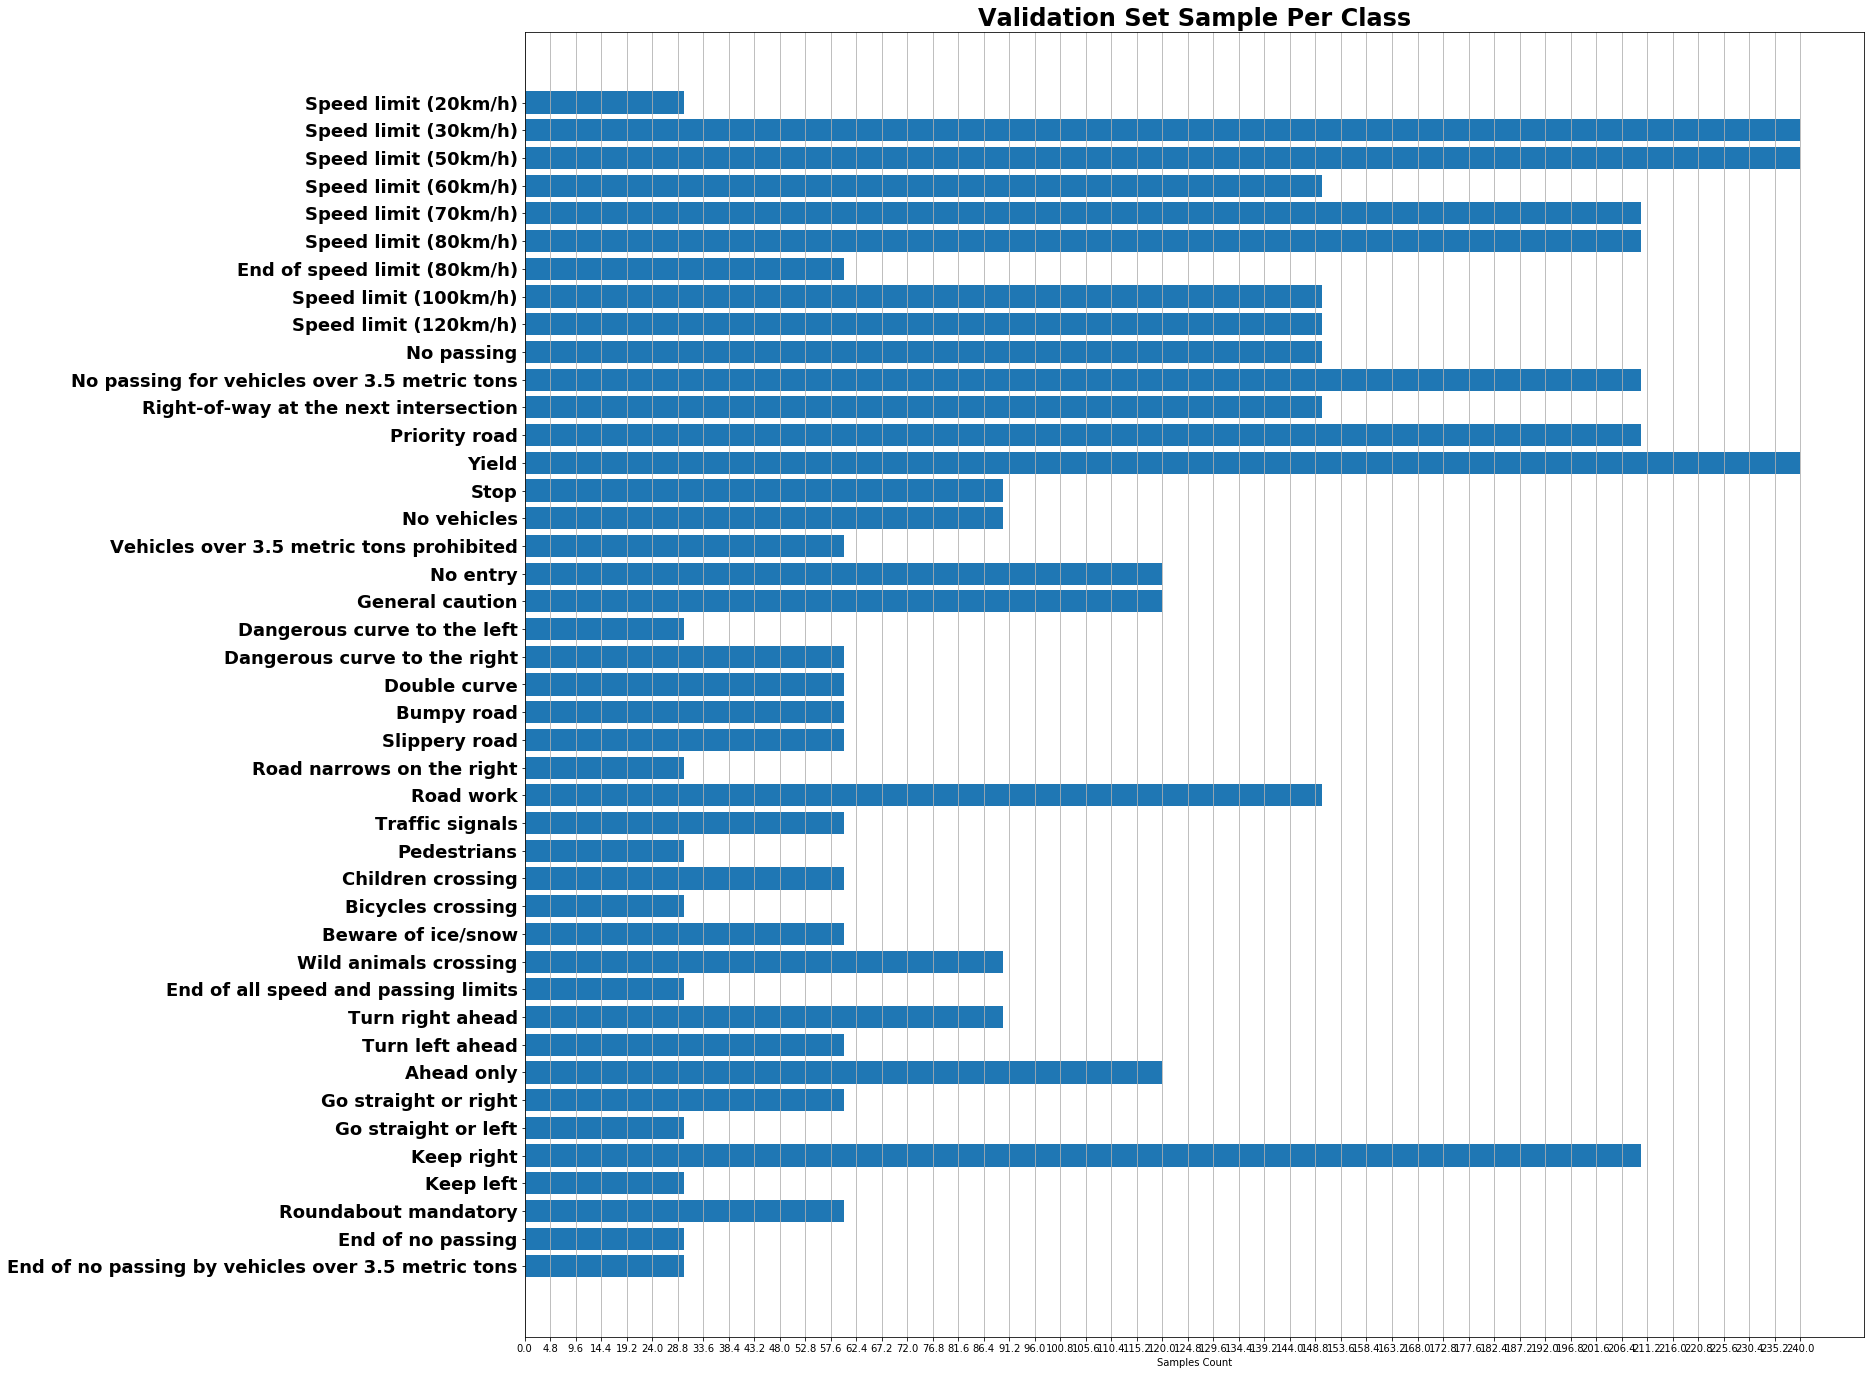

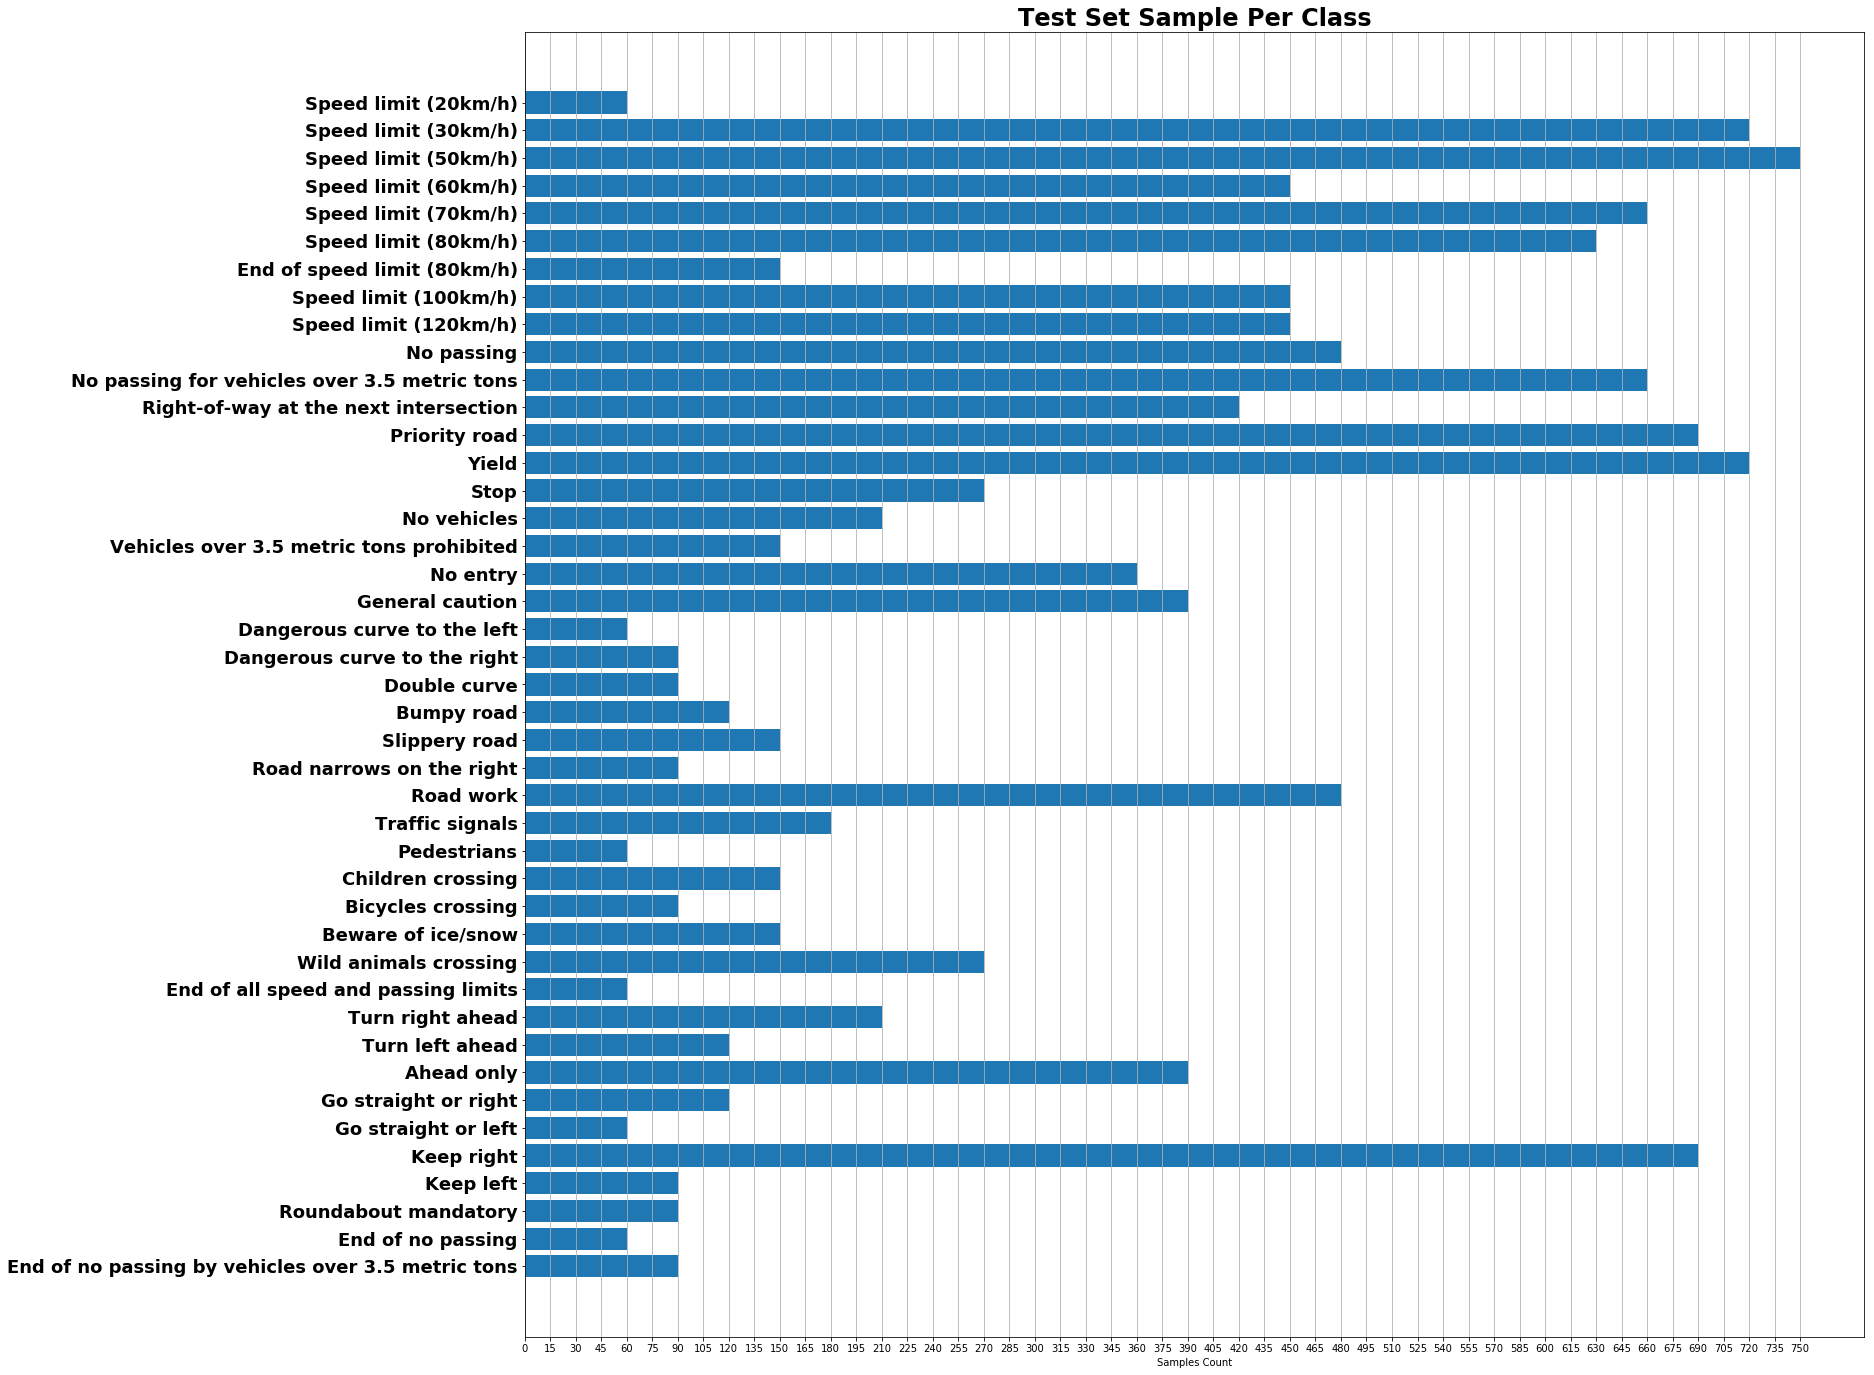

In [456]:
# Dataset Balancing inspection

def show_set_balancing(set_labels, name='Generic Set'):
    (unique, counts) = np.unique(set_labels, return_counts=True)
    class_counts = np.asarray((unique, counts)).T
    
    # Label position arangement
    label_pos = np.arange(len(class_labels))
    
    f, ax = plt.subplots(figsize=(24,24))
    ax.barh(unique, counts, align='center')
    
    # Major ticks every 50
    major_ticks = np.arange(0, max(counts)+1, max(counts)/50)
    ax.set_xticks(major_ticks)

    ax.grid(axis='x')
    ax.set_yticks(label_pos)
    ax.set_yticklabels(class_labels, {'fontsize': 18,'fontweight': 'bold'})
    ax.invert_yaxis()  # labels read top-to-bottom
    ax.set_xlabel('Samples Count')
    ax.set_title(name+' Sample Per Class', {'fontsize': 24,'fontweight': 'bold'})
    
    
    
    
show_set_balancing(training_set_labels, 'Training Set')
show_set_balancing(validation_set_labels, 'Validation Set')
show_set_balancing(test_set_labels, 'Test Set')

## Training Set Inspection 

Firstly a PieChart of training set is showed. 
Then, most and least occurring classes are listed

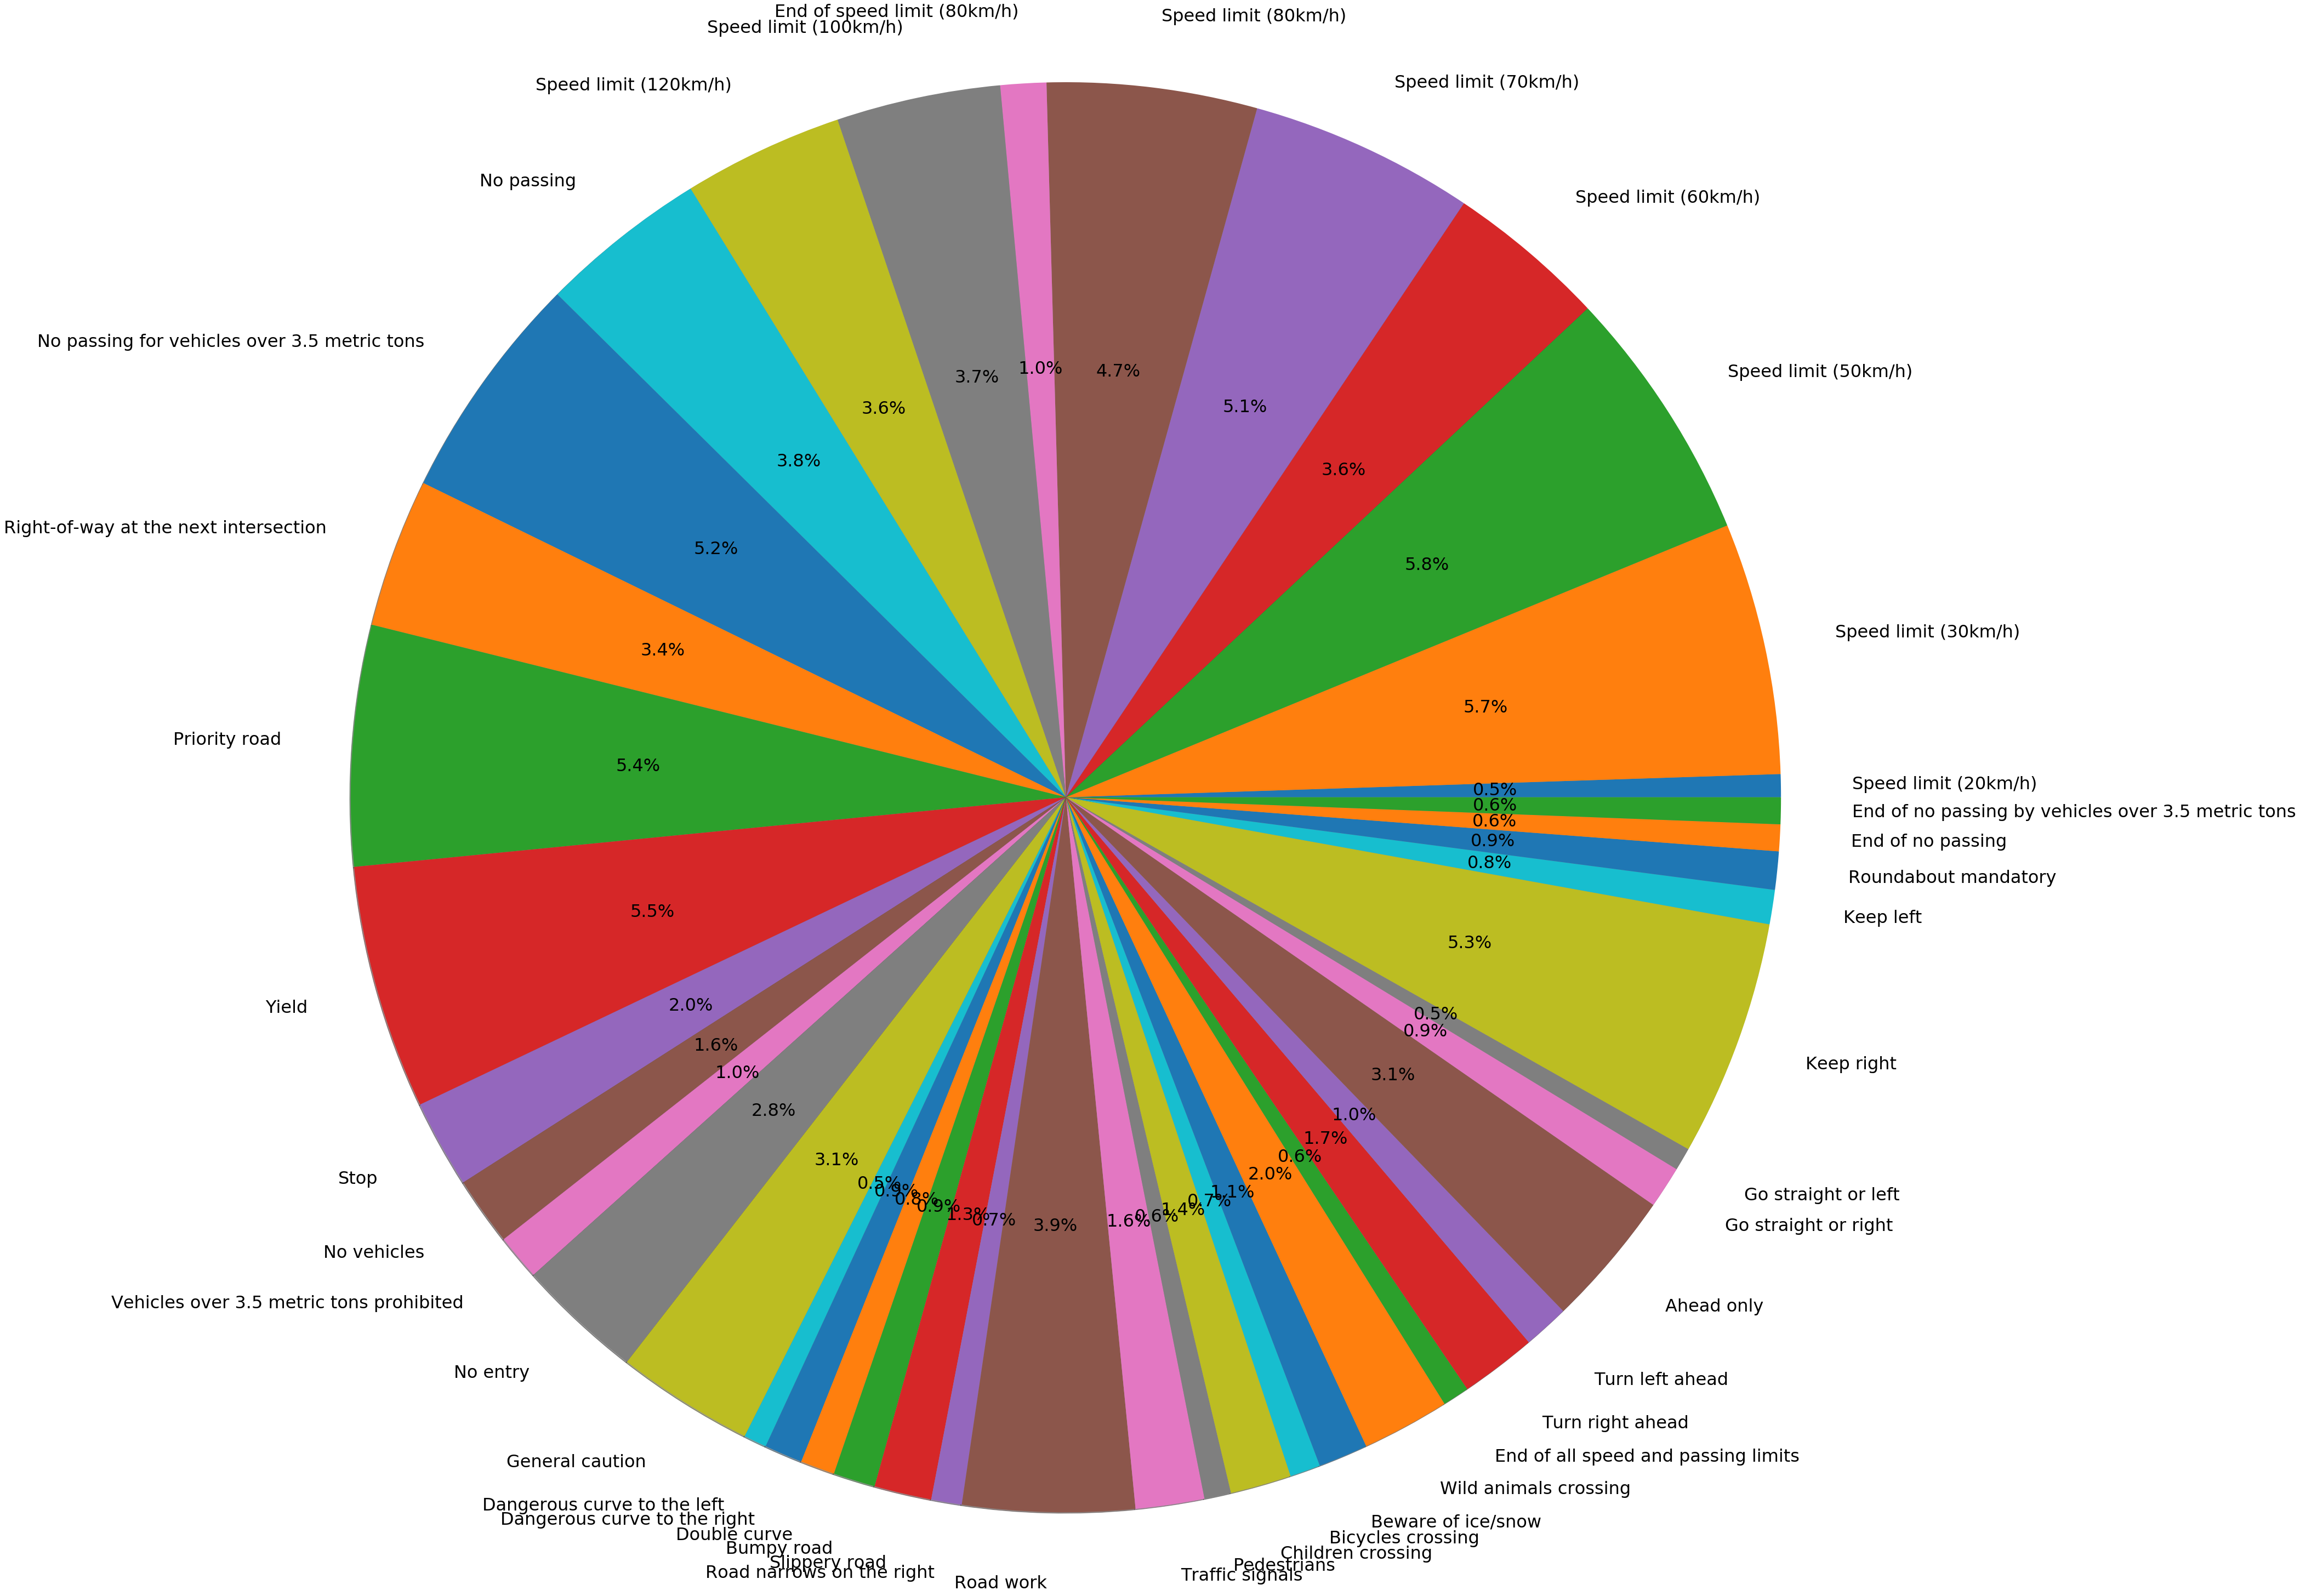

Most occurred class :  Speed limit (50km/h)  Freq: 5.776 %
Least occurred class :  Speed limit (20km/h)  Freq: 0.517 %


In [457]:

(unique, counts) = np.unique(training_set_labels, return_counts=True)
patches, texts, autotexts = plt.pie(counts, autopct='%1.1f%%', shadow=True, 
                                    labels=class_labels, textprops={'fontsize': 32}, radius=15)
[ _.set_fontsize(32) for _ in texts ]
plt.show()


# Compute most and least occurring classes
class_frequencies = np.asarray((unique, counts/n_train)).T

most_occurred = max(class_frequencies, key=lambda x:x[1])
least_occurred = min(class_frequencies, key=lambda x:x[1])

print('Most occurred class : ', class_labels[int(most_occurred[0])], " Freq: {:.3f} %".format(most_occurred[1]*100.0))
print('Least occurred class : ', class_labels[int(least_occurred[0])], " Freq: {:.3f} %".format(least_occurred[1]*100.0))


## Balancing Technique

 1. Class Weights
 2. Oversampling

From https://www.tensorflow.org/tutorials/structured_data/imbalanced_data#class_weights


----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

## Preprocess Data

Shuffle the training data.


In [458]:


training_set_samples_loaded, training_set_labels = shuffle(training_set_samples_loaded, training_set_labels)

## Image Preprocessing

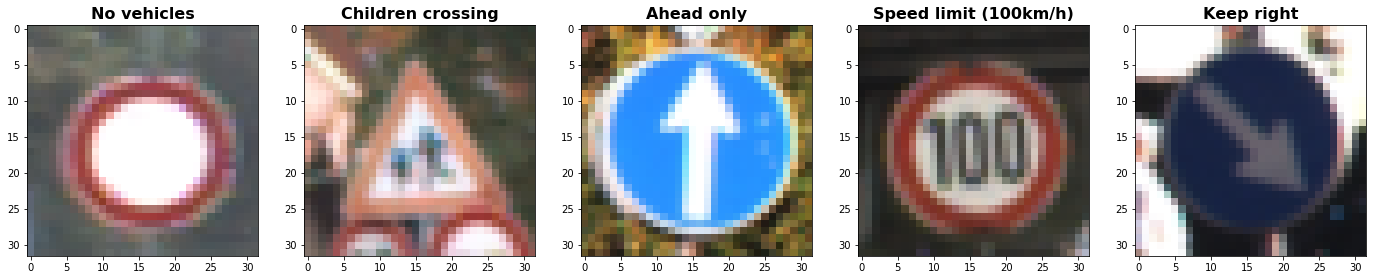

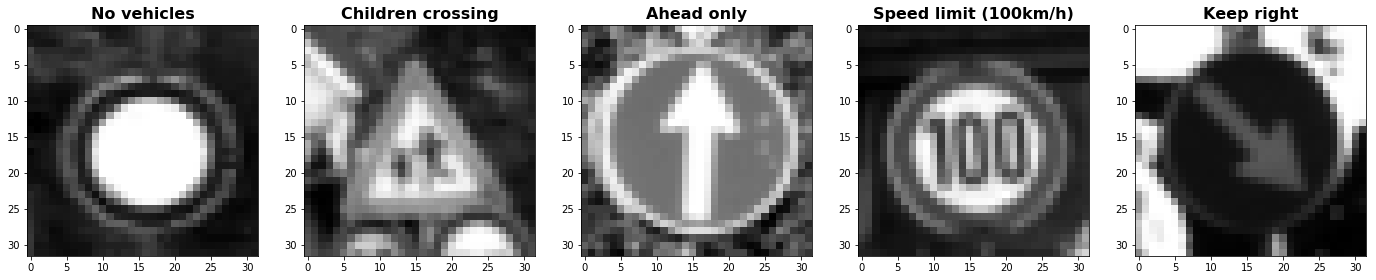

In [459]:

def preprocess_image(img):
    
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    pixels = np.asarray(gray)
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # compute mean std
    mean, std = pixels.mean(), pixels.std()
    # global standardization of pixels
    pixels = (pixels - mean) / std
    
    return pixels.reshape(32,32,1)
    

sample_images = training_set_samples_loaded[indices]
plot_images(sample_images, class_labels[training_set_labels[indices]])
processed_sample_images = [preprocess_image(img) for img in sample_images]
plot_images(processed_sample_images, class_labels[training_set_labels[indices]])

## Dataset Preprocessing

In [460]:
def preprocess_dataset(dataset):
    els = [preprocess_image(img) for img in dataset]
    return np.array(els)


training_set_samples = preprocess_dataset(training_set_samples_loaded)
validation_set_samples = preprocess_dataset(validation_set_samples)
test_set_samples = preprocess_dataset(test_set_samples)
print('Preprocessing Complete!')
print('Training, Validation and Test set have been preprocessed!')


Preprocessing Complete!
Training, Validation and Test set have been preprocessed!


In [461]:
'''
FOR VISUALIZATION
    pixels = np.asarray(image)
    
    # confirm pixel range is 0-255
    print('Data Type: %s' % pixels.dtype)
    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))
    # convert from integers to floats
    pixels = pixels.astype('float32')
    # calculate global mean and standard deviation
    mean, std = pixels.mean(), pixels.std()
    print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))
    # global standardization of pixels
    pixels = (pixels - mean) / std
    # confirm it had the desired effect
    mean, std = pixels.mean(), pixels.std()
    print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))

dataset(test_x_vect)

'''

"\nFOR VISUALIZATION\n    pixels = np.asarray(image)\n    \n    # confirm pixel range is 0-255\n    print('Data Type: %s' % pixels.dtype)\n    print('Min: %.3f, Max: %.3f' % (pixels.min(), pixels.max()))\n    # convert from integers to floats\n    pixels = pixels.astype('float32')\n    # calculate global mean and standard deviation\n    mean, std = pixels.mean(), pixels.std()\n    print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))\n    # global standardization of pixels\n    pixels = (pixels - mean) / std\n    # confirm it had the desired effect\n    mean, std = pixels.mean(), pixels.std()\n    print('Mean: %.3f, Standard Deviation: %.3f' % (mean, std))\n\ndataset(test_x_vect)\n\n"

## Setup TensorFlow
The `EPOCH` and `BATCH_SIZE` values affect the training speed and model accuracy.


In [462]:

EPOCHS = 10
BATCH_SIZE = 256

##  LeNet-5 Architecture
Implement the [LeNet-5](http://yann.lecun.com/exdb/lenet/) neural network architecture.

This is the only cell you need to edit.
### Input
The LeNet architecture accepts a 32x32xC image as input, where C is the number of color channels. Since MNIST images are grayscale, C is 1 in this case.

### Architecture
**Layer 1: Convolutional.** The output shape should be 28x28x6.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 14x14x6.

**Layer 2: Convolutional.** The output shape should be 10x10x16.

**Activation.** Your choice of activation function.

**Pooling.** The output shape should be 5x5x16.

**Flatten.** Flatten the output shape of the final pooling layer such that it's 1D instead of 3D. The easiest way to do is by using `tf.contrib.layers.flatten`, which is already imported for you.

**Layer 3: Fully Connected.** This should have 120 outputs.

**Activation.** Your choice of activation function.

**Layer 4: Fully Connected.** This should have 84 outputs.

**Activation.** Your choice of activation function.

**Layer 5: Fully Connected (Logits).** This should have 10 outputs.

### Output
Return the result of the 2nd fully connected layer.

### Model Implementation

In [463]:

def LeNet(x):    
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # ADDON: dropout
    fc0 = tf.nn.dropout(fc0, keep_prob)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    
    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, n_classes), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(n_classes))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1, conv2

## Features and Labels
Train LeNet to classify traffic signs
`x` is a placeholder for a batch of input images.
`y` is a placeholder for a batch of output labels.


In [464]:
input_size_list = list(image_shape)
input_size_list.insert(0,None)
input_size = tuple(input_size_list)
print('Input layer size: ', input_size)

x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))

one_hot_y = tf.one_hot(y, n_classes)

keep_prob = tf.placeholder(tf.float32)

Input layer size:  (None, 32, 32, 3)


## Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

## Training Pipeline
Create a training pipeline that uses the model to classify MNIST data.


In [465]:
rate = 0.00089

logits, conv1, conv2 = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

## Model Evaluation
Evaluate how well the loss and accuracy of the model for a given dataset.


In [466]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples


prediction_operation = tf.argmax(logits, 1)
y_operation = tf.argmax(one_hot_y, 1)

def evaluate_prediction(X_data, y_data):
    num_examples = len(X_data)
    predictions = list()
    labels = list()

    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        predictions_val, y_val = sess.run([prediction_operation, y_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        
        predictions.extend(predictions_val)
        labels.extend(y_val)

    return predictions, labels


## Train the Model
Run the training data through the training pipeline to train the model.

Before each epoch, shuffle the training set.

After each epoch, measure the loss and accuracy of the validation set.

Save the model after training.


In [467]:
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    train_accuracy_history = list()
    valid_accuracy_history = list()
    loss_history = list()
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(training_set_samples, training_set_labels)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            _, curr_loss = sess.run([training_operation, loss_operation], feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(validation_set_samples, validation_set_labels)
        train_accuracy = evaluate(training_set_samples, training_set_labels)
        
        train_accuracy_history.append(train_accuracy)
        valid_accuracy_history.append(validation_accuracy)
        loss_history.append(curr_loss)  

        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, os.path.join(output_path,'lenet'))
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.670

EPOCH 2 ...
Validation Accuracy = 0.821

EPOCH 3 ...
Validation Accuracy = 0.863

EPOCH 4 ...
Validation Accuracy = 0.888

EPOCH 5 ...
Validation Accuracy = 0.904

EPOCH 6 ...
Validation Accuracy = 0.919

EPOCH 7 ...
Validation Accuracy = 0.925

EPOCH 8 ...
Validation Accuracy = 0.924

EPOCH 9 ...
Validation Accuracy = 0.935

EPOCH 10 ...
Validation Accuracy = 0.937

Model saved


Text(0, 0.5, 'Loss')

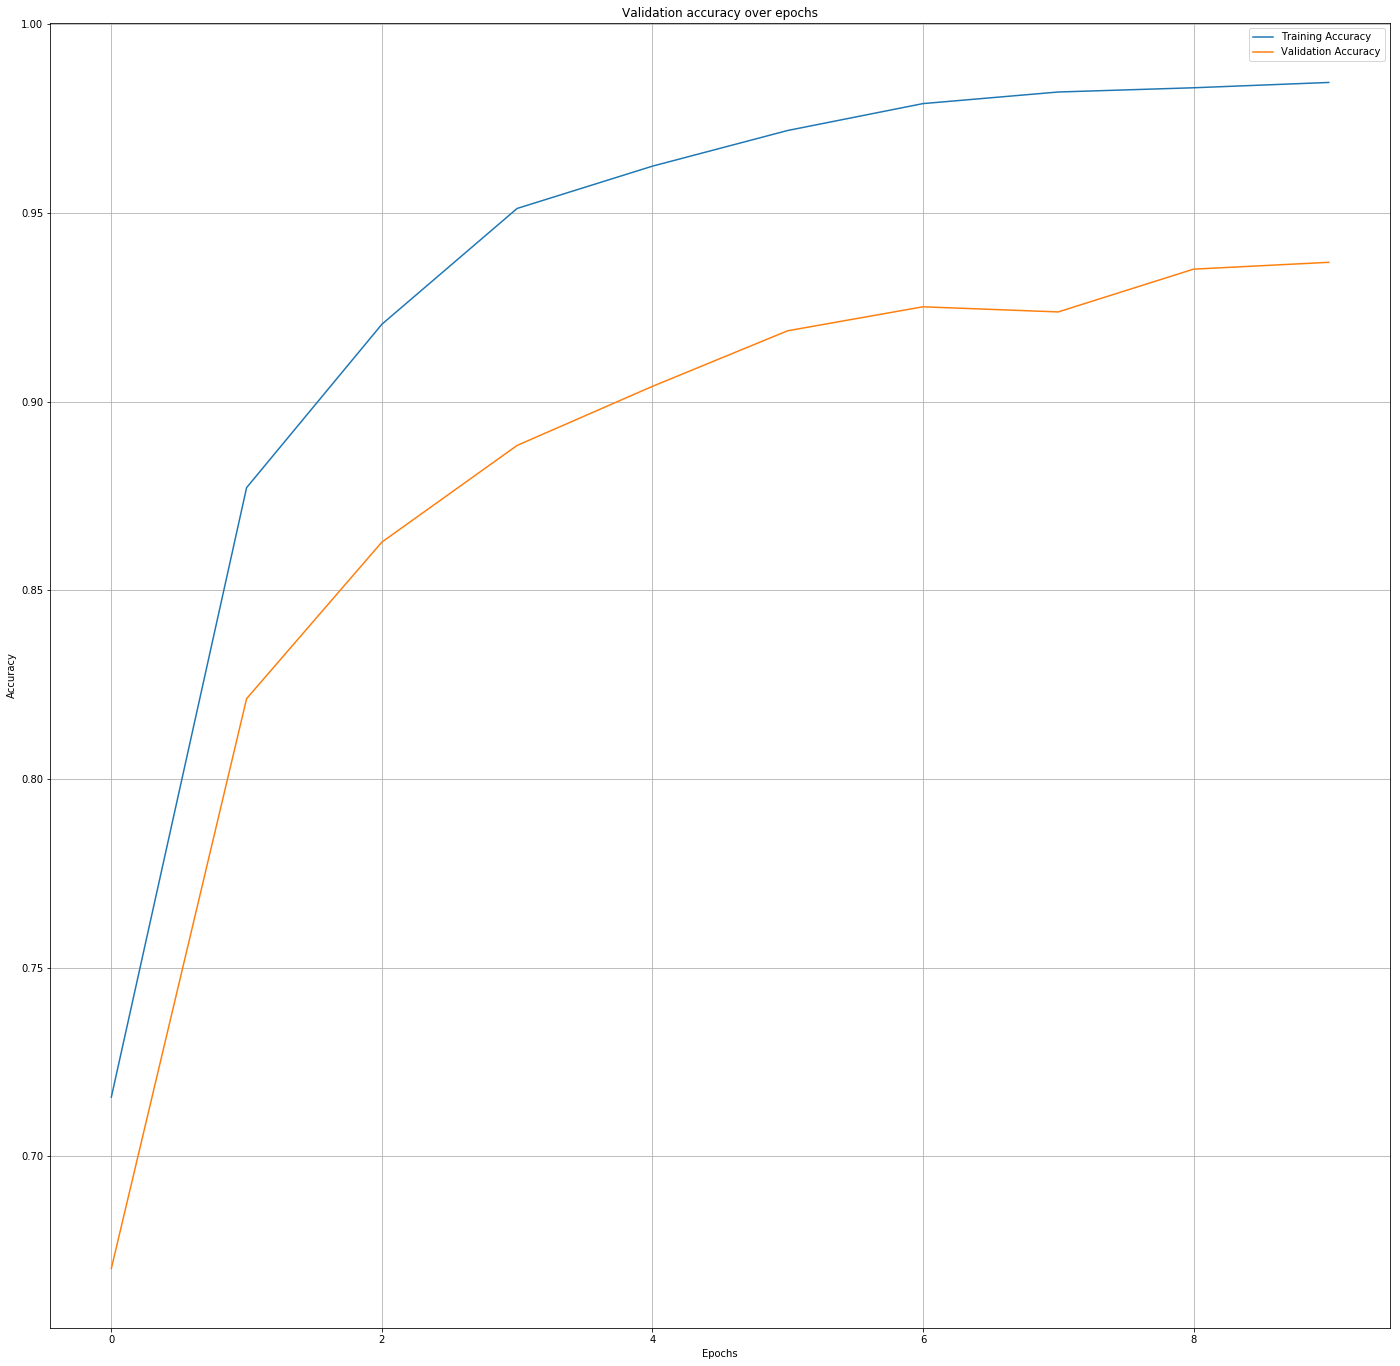

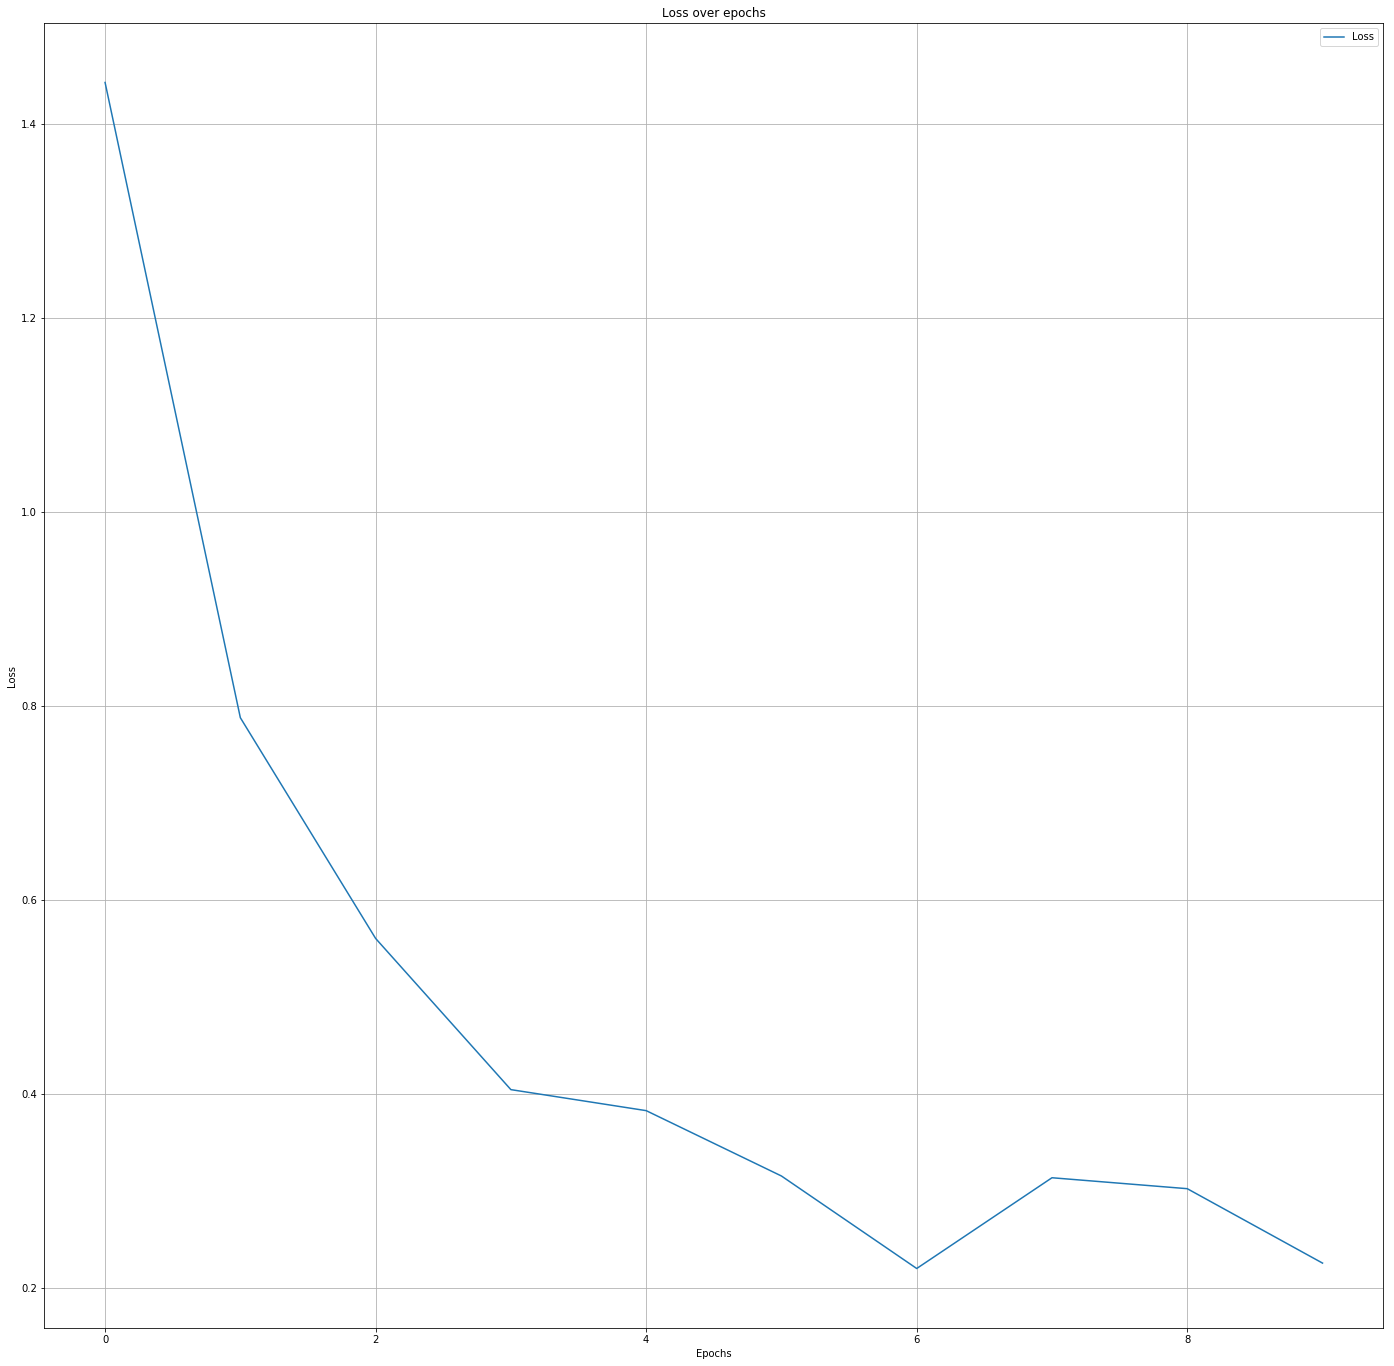

In [468]:
f,ax = plt.subplots(figsize=(24,24))

ax.plot(range(EPOCHS), train_accuracy_history, label='Training Accuracy')
ax.grid()
ax.set_title('Training accuracy over epochs')

ax.plot(range(EPOCHS), valid_accuracy_history, label='Validation Accuracy')
ax.set_title('Validation accuracy over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.legend()


f,ax = plt.subplots(figsize=(24,24))

ax.plot(range(EPOCHS), loss_history, label='Loss')
ax.grid()
ax.legend()
ax.set_title('Loss over epochs')
ax.set_xlabel('Epochs')
ax.set_ylabel('Loss')

## Evaluate the Model
Once you are completely satisfied with your model, evaluate the performance of the model on the test set.

Be sure to only do this once!

If you were to measure the performance of your trained model on the test set, then improve your model, and then measure the performance of your model on the test set again, that would invalidate your test results. You wouldn't get a true measure of how well your model would perform against real data.


In [470]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(output_path))

    training_set_accuracy = evaluate(training_set_samples, training_set_labels)
    print("Training Set Accuracy = {:.3f}".format(training_set_accuracy))
    
    validation_set_accuracy = evaluate(validation_set_samples, validation_set_labels)
    print("Validation Set Accuracy = {:.3f}".format(validation_set_accuracy))
    
    test_accuracy = evaluate(test_set_samples, test_set_labels)
    print("Test Set Accuracy = {:.3f}".format(test_accuracy))

INFO:tensorflow:Restoring parameters from saved_model/lenet
Training Set Accuracy = 0.985
Validation Set Accuracy = 0.937
Test Set Accuracy = 0.918


## Training Metrics

Print the confusion matrix for showing dependancies between classifications

In [ ]:

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(output_path))
    y_pred, y_true = evaluate_prediction(test_set_samples, test_set_labels)
    


test_pred = np.array(y_pred)
test_true = np.array(y_true)
cm = metrics.confusion_matrix(test_true, test_pred)
#print()
fig = plt.figure(figsize=(48,48))
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Oranges)
plt.title('Confusion matrix of the classifier', {'fontsize':28, 'fontweight':'bold'})
fig.colorbar(cax)

ax.set_xticks(np.arange(1, n_classes+1, 1))
ax.set_yticks(np.arange(0, n_classes, 1))
plt.xticks(rotation=45)

ax.set_xticklabels(class_labels, {'fontweight':'bold'})
ax.set_yticklabels(class_labels, {'fontweight':'bold'})
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Precision talks about how precise/accurate your model is out of those predicted positive, how many of them are actual positive.')
# High Precision limit the cost of a False Positive
# Recall actually calculates how many of the Actual Positives our model capture through labeling it as Positive')
# High Recall limit the cost of False Negative
# F1 Score might be a better measure to use if we need to seek a balance between Precision and Recall')


# Print the precision and recall, among other metrics
classification_report = metrics.classification_report(test_true, test_pred, 
                                                      digits=3, target_names=class_labels,
                                                     output_dict=True)

print(metrics.classification_report(test_true, test_pred, digits=3, target_names=class_labels))




In [ ]:
def print_precision_dict(dictionary):
    print({k:round(v,3) if isinstance(v,float) else v for k,v in dictionary.items()})
    
classification_report = {k: v for k, v in classification_report.items() if isinstance(v,dict)}

worst_score = min(classification_report.values(), key=lambda x: x['f1-score']) 

worsts_filter = filter(lambda x: x['f1-score'] < 0.85,classification_report.values())

worsts = list(worsts_filter)

for bad_score in worsts:
    bad_label = list(classification_report.keys())[
        list(classification_report.values()).index(bad_score)]
    
    print(bad_label)
    print_precision_dict(bad_score)

    bad_label_num = labels.loc[labels['SignName']==bad_label].iloc[0][0]

    bad_indices = np.where(training_set_labels == bad_label_num)

    plot_images(training_set_samples[bad_indices[0][0:5]])


---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

In [ ]:
# Populate new test set labels

In [ ]:
### Load the images and plot them here.

new_images_path = glob.glob('./web_images/*.jpg')
new_images = list()

for image_path in new_images_path:
    image = mpimg.imread(image_path)
    new_images.append(image)
    
new_test_set_labels_indices = list()

#new_test_set_labels_indices.append(labels.loc[labels['SignName']=='General caution'].iloc[0][0])
#new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Speed limit (30km/h)'].iloc[0][0])
#new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Slippery road'].iloc[0][0])
#new_test_set_labels_indices.append(labels.loc[labels['SignName']=='No entry'].iloc[0][0])
#new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Keep right'].iloc[0][0])
#new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Bumpy road'].iloc[0][0])
new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Speed limit (50km/h)'].iloc[0][0])
new_test_set_labels_indices.append(labels.loc[labels['SignName']=='No passing'].iloc[0][0])
new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Children crossing'].iloc[0][0])
new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Go straight or right'].iloc[0][0])
new_test_set_labels_indices.append(labels.loc[labels['SignName']=='Yield'].iloc[0][0])

new_test_set_labels = class_labels[new_test_set_labels_indices]
print('New Test Set Labels: ',new_test_set_labels)

plot_images(new_images, new_test_set_labels)


### Predict the Sign Type for Each Image

In [ ]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.

# PreProcessing

processed_new_images = list()

for image in new_images:
    image = cv2.resize(image, (32,32), interpolation = cv2.INTER_AREA)
    processed_new_images.append(preprocess_image(image))

    
plot_images(processed_new_images, new_test_set_labels)


new_test_set_samples = processed_new_images
    

### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tf.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [ ]:
# Run the model on
k_num = 5
softmax_logits = tf.nn.softmax(logits)
top_k = tf.nn.top_k(softmax_logits, k=k_num)


def predict_batch(x_batch, y_batch):
    
    batch_top_k = list()
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, tf.train.latest_checkpoint(output_path))
        top_k_result = sess.run(top_k, feed_dict={x:x_batch, y:y_batch, keep_prob:1.0})
        batch_top_k.append((top_k_result))
        
    return batch_top_k

        
top_k_predictions = predict_batch(new_test_set_samples, new_test_set_labels_indices)
print('Predictions over new test images completed!')

In [ ]:
f,axes = plt.subplots(len(new_test_set_samples), 2, figsize=(24,24))

for ind,image in enumerate(new_test_set_samples):
    image_ax = axes[ind][0]
    top_k_ax = axes[ind][1]
    
    image_ax.imshow(image.squeeze(axis=2), cmap='gray')
    
    top_k_ax.barh(np.arange(0, 5, 1), top_k_predictions[0].values[ind])
        
    top_k_lab_num = top_k_predictions[0].indices[ind]

    top_k_labels = class_labels[top_k_predictions[0].indices[ind]]
    
    top_k_ax.grid(axis='x')
    top_k_ax.set_yticks(np.arange(0, 5, 1))
    top_k_ax.set_yticklabels(top_k_labels, {'fontweight':'bold', 'fontsize':12})
        

### Analyze Performance

In [ ]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.


with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint(output_path))
    
    new_test_accuracy = evaluate(new_test_set_samples, new_test_set_labels_indices)
    print("New Test Set Accuracy = {:.3f}".format(new_test_accuracy))



### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 : Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [ ]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    image_input = preprocess_image(image_input)
    image_input = np.expand_dims(image_input, axis=0)
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")
            


indices = np.random.randint(0, n_train, size=3)
sample_images = training_set_samples_loaded[indices]
sample_labels = class_labels[training_set_labels[indices]]

for ind, test_fmap_image in enumerate(sample_images):
    with tf.Session() as sess:
        saver.restore(sess, tf.train.latest_checkpoint(output_path))
        # Test image visualization
        print('Test Image : ', sample_labels[ind])
        f, a = plt.subplots()
        a.imshow(test_fmap_image)
        plt.show()
        
        # First convolutional layer feature map
        outputFeatureMap(test_fmap_image, conv1, plt_num=1)
        
        # Second convolutional layer feature map
        outputFeatureMap(test_fmap_image, conv2, plt_num=2)
    
